In [2]:
# !python -m pip install langchain-text-splitters ragas --quiet

In [28]:
import os
import numpy as np
import pandas as pd
from typing import List, Optional, Tuple, Dict, TypedDict
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from sklearn.metrics.pairwise import cosine_similarity
from langchain_community.vectorstores import FAISS
from langchain.schema import Document
from ragas import evaluate
from ragas import evaluate, SingleTurnSample, EvaluationDataset
from ragas.metrics import AnswerRelevancy, Faithfulness, ContextPrecision
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain.prompts import ChatPromptTemplate
from pinecone import Pinecone, ServerlessSpec
from langgraph.graph import StateGraph, END
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_pinecone import PineconeVectorStore
import mlflow
import json
import time
from datasets import Dataset
from tqdm import tqdm

In [29]:
import mlflow
print(mlflow.__version__)

3.3.2


In [4]:
from dotenv import load_dotenv
load_dotenv()

True

### Load the knowledge base JSON

In [5]:

with open('self_critique_loop_dataset.json', 'r') as f:
    kb_data = json.load(f)

In [6]:
kb_data[0]

{'doc_id': 'KB001',
 'question': 'What are best practices for debugging?',
 'answer_snippet': "When addressing debugging, it's important to follow well-defined patterns...",
 'source': 'debugging_guide.md',
 'confidence_indicator': 'moderate',
 'last_updated': '2024-01-10'}

### Initializing LLM & Embedding Models

In [7]:
client = AzureChatOpenAI(
    deployment_name=os.environ['AZURE_OPENAI_DEPLOYMENT'],  # Your deployment name
        model_name="gpt-4o",
        temperature=0.1
)

In [8]:
# Quick LLM Invokation test to verify model deployment

client.invoke('What is the capital of France?').content 

'The capital of France is Paris.'

In [9]:

embedding_model = AzureOpenAIEmbeddings(
    model="text-embedding-ada-002",
)

In [10]:
# Quick Embedding model test to verify model deployment

test_emb = embedding_model.embed_query("The quick brown fox jumps over the lazy dog")
print(test_emb[:10]) 
emb_model_len = len(test_emb)

[-0.0035696455743163824, 0.008301939815282822, -0.014215736649930477, -0.004543756600469351, -0.01546008512377739, 0.01862751692533493, -0.02047518640756607, -0.010218738578259945, -0.012883404269814491, -0.028129812330007553]


In [11]:
# Quick Similarity Test

print("Cosine Similarity:",cosine_similarity(
    np.array(embedding_model.embed_query("It's a lovely day outside")).reshape(-1, 1),
    np.array(embedding_model.embed_query("The weather today is beautiful")).reshape(-1,1)
)[0][0])

Cosine Similarity: 1.0


### Initializing Pinecone Vector DB

In [12]:

PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
if not PINECONE_API_KEY:
    raise RuntimeError("PINECONE_API_KEY not found. Please set it in your environment.")
else:
  print("PINECONE API KEY found")

pc = Pinecone(api_key=PINECONE_API_KEY)

PINECONE API KEY found


In [13]:
INDEX_NAME = "kc-tmp-pinecone-index" # you can change the name - trial version allows only one index per account, you can login to pinecone and delete the index if needed
METRIC = "cosine"

if INDEX_NAME in [idx["name"] for idx in pc.list_indexes()]:
    pc.delete_index(INDEX_NAME)
    print("Found Index, Deleting for clean up")

In [14]:
# Create the index if it doesn't exist
existing = [idx["name"] for idx in pc.list_indexes()]
if INDEX_NAME not in existing:
    print(f"Creating index '{INDEX_NAME}' ...")
    pc.create_index(
        name=INDEX_NAME,
        dimension=emb_model_len,
        metric=METRIC,
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),)
   
    time.sleep(5)  # optional: wait a moment for the index to be ready
else:
    print(f"Index '{INDEX_NAME}' already exists, reusing it.")

index = pc.Index(INDEX_NAME)
print(index.describe_index_stats())

Creating index 'kc-tmp-pinecone-index' ...
{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}


### Create LangChain documents

In [15]:

documents = []
for entry in kb_data:
    doc_id = entry['doc_id']
    question = entry['question']
    answer = entry['answer_snippet']
    source = entry.get('source', 'unknown')
    
    # Combine question and answer for better semantic search
    content = f"Question: {question}\nAnswer: {answer}"
    
    doc = Document(
        page_content=content,
        metadata={
            'doc_id': doc_id,
            'question': question,
            'source': source
        }
    )
    documents.append(doc)

### Adding Docs to Vector DB

In [16]:
vectorstore = PineconeVectorStore(
    index_name=INDEX_NAME,
    embedding=embedding_model,
    namespace=None,           # set a namespace string if you want to isolate data
    pinecone_api_key=PINECONE_API_KEY,  # optional; will default to env var
)

In [17]:
vectorstore.add_documents(documents)
time.sleep(5)  # Wait for indexing
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

### Define LangGraph State

In [19]:
class AgentState(TypedDict):
    """State that flows through the graph"""
    query: str
    retrieved_snippets: List[Dict]
    initial_answer: str
    critique_result: str
    refined_answer: str
    final_answer: str
    needs_refinement: bool
    refinement_snippet: Dict

#### Node 1 - Retriever Node

In [32]:
def retriever_node(state: AgentState) -> AgentState:
    """
    Retrieves top-5 KB snippets based on the query.
    Each snippet is up to 5 KB in size.
    """
    query = state['query']
    print(f"\n🔍 RETRIEVER NODE")
    print(f"Query: {query}")
    
    # Retrieve top 5 documents
    results = vectorstore.similarity_search_with_score(query, k=5)
    
    snippets = []
    for doc, score in results:
        snippet = {
            'doc_id': doc.metadata['doc_id'],
            'content': doc.page_content[:5000],  # Limit to 5KB
            'score': float(score)
        }
        snippets.append(snippet)
        print(f"  Retrieved: {snippet['doc_id']} (score: {score:.4f})")
    
    state['retrieved_snippets'] = snippets
    return state

#### Node 2: LLM Answer Node

In [33]:


def llm_answer_node(state: AgentState) -> AgentState:
    """
    Generates initial answer using Azure GPT-4 mini with citations.
    Citations format: [KBxxx]
    """
    query = state['query']
    snippets = state['retrieved_snippets']
    
    print(f"\n烙 LLM ANSWER NODE")
    
    # Build context with citations
    context = ""
    for snippet in snippets:
        context += f"\n[{snippet['doc_id']}]:\n{snippet['content']}\n"
    
    # Create prompt
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant that answers questions based on the provided knowledge base snippets.

IMPORTANT: You MUST cite sources using the format [KBxxx] where xxx is the knowledge base ID.
- Use citations after each relevant statement
- Only use information from the provided snippets
- If information is not in the snippets, say so clearly"""),
        ("user", """Question: {query}

Knowledge Base Snippets:
{context}

Provide a comprehensive answer with proper citations [KBxxx].""")
    ])
    
    chain = prompt | client
    response = chain.invoke({"query": query, "context": context})
    
    answer = response.content
    state['initial_answer'] = answer
    
    print(f"Generated answer length: {len(answer)} characters")
    print(f"Answer preview: {answer[:200]}...")
    
    return state

 #### Node 3: Self-Critique Node

In [34]:
def self_critique_node(state: AgentState) -> AgentState:
    """
    Uses GPT-4o to critique if the answer is COMPLETE or needs REFINE.
    """
    query = state['query']
    answer = state['initial_answer']
    
    print(f"\n🔍 SELF-CRITIQUE NODE")
    
    # Critique prompt
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a strict answer quality evaluator. 
Evaluate if the answer is COMPLETE or needs REFINEMENT.

Return ONLY one word:
- "COMPLETE" if the answer fully addresses the question with sufficient detail
- "REFINE" if the answer is incomplete, vague, or missing important details

Be strict in your evaluation."""),
        ("user", """Question: {query}

Answer: {answer}

Evaluation (COMPLETE or REFINE):""")
    ])
    
    chain = prompt | client  # Using the same GPT-4o client
    response = chain.invoke({"query": query, "answer": answer})
    
    critique = response.content.strip().upper()
    
    # Ensure valid response
    if "COMPLETE" in critique:
        critique = "COMPLETE"
    elif "REFINE" in critique:
        critique = "REFINE"
    else:
        critique = "COMPLETE"  # Default to complete if unclear
    
    state['critique_result'] = critique
    state['needs_refinement'] = (critique == "REFINE")
    
    print(f"Critique Result: {critique}")
    
    return state

#### Node 4: Refinement Node

In [35]:
def refinement_node(state: AgentState) -> AgentState:
    """
    Retrieves 1 additional snippet and regenerates answer.
    """
    query = state['query']
    initial_snippets = state['retrieved_snippets']
    initial_answer = state['initial_answer']
    
    print(f"\n REFINEMENT NODE")
    
    # Get one more snippet (6th result)
    results = vectorstore.similarity_search_with_score(query, k=6)
    
    if len(results) > 5:
        doc, score = results[5]
        additional_snippet = {
            'doc_id': doc.metadata['doc_id'],
            'content': doc.page_content[:5000],
            'score': float(score)
        }
        print(f"  Additional snippet: {additional_snippet['doc_id']} (score: {score:.4f})")
    else:
        additional_snippet = None
        print("  No additional snippet available")
    
    state['refinement_snippet'] = additional_snippet
    
    # Build enhanced context
    all_snippets = initial_snippets.copy()
    if additional_snippet:
        all_snippets.append(additional_snippet)
    
    context = ""
    for snippet in all_snippets:
        context += f"\n[{snippet['doc_id']}]:\n{snippet['content']}\n"
    
    # Regenerate answer with additional context
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant that answers questions based on the provided knowledge base snippets.

IMPORTANT: You MUST cite sources using the format [KBxxx] where xxx is the knowledge base ID.
- Use citations after each relevant statement
- Only use information from the provided snippets
- Provide a more comprehensive answer than before"""),
        ("user", """Question: {query}

Previous Answer (needs improvement):
{previous_answer}

Enhanced Knowledge Base Snippets:
{context}

Provide an improved, more comprehensive answer with proper citations [KBxxx].""")
    ])
    
    chain = prompt | client
    response = chain.invoke({
        "query": query,
        "previous_answer": initial_answer,
        "context": context
    })
    
    refined_answer = response.content
    state['refined_answer'] = refined_answer
    
    print(f"Refined answer length: {len(refined_answer)} characters")
    
    return state

#### Decision Function

In [36]:
def decide_refinement(state: AgentState) -> str:
    """
    Decision function: routes to refinement or end based on critique.
    """
    if state['needs_refinement']:
        print("\n➡️  Routing to REFINEMENT")
        return "refine"
    else:
        print("\n➡️  Routing to END (answer complete)")
        return "end"

### Build LangGraph Workflow

In [37]:
# Create graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("retriever", retriever_node)
workflow.add_node("llm_answer", llm_answer_node)
workflow.add_node("critique", self_critique_node)
workflow.add_node("refinement", refinement_node)

# Define edges
workflow.set_entry_point("retriever")
workflow.add_edge("retriever", "llm_answer")
workflow.add_edge("llm_answer", "critique")

# Conditional edge based on critique
workflow.add_conditional_edges(
    "critique",
    decide_refinement,
    {
        "refine": "refinement",
        "end": END
    }
)

# After refinement, end
workflow.add_edge("refinement", END)

# Compile graph
app = workflow.compile()

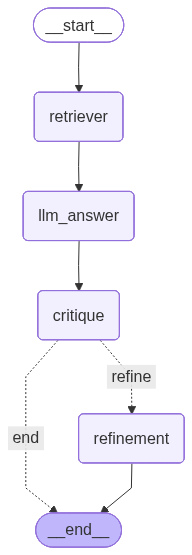

In [38]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Test Queries

In [39]:
test_queries = [
    "What are best practices for caching?",
    "How should I set up CI/CD pipelines?",
    "What are performance tuning tips?",
    "How do I version my APIs?",
    "What should I consider for error handling?"
]

In [ ]:
# import mlflow
# mlflow.langchain.autolog()

In [40]:
mlflow.set_tracking_uri("http://20.75.92.162:5000")
mlflow.set_experiment("kc-agentic_rag_self_critique")

2025/10/05 20:38:38 INFO mlflow.tracking.fluent: Experiment with name 'kc-agentic_rag_self_critique' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/967319295578521028', creation_time=1759676918762, experiment_id='967319295578521028', last_update_time=1759676918762, lifecycle_stage='active', name='kc-agentic_rag_self_critique', tags={}>

In [ ]:
results = []

for i, query in enumerate(test_queries[:1], 1):
    print(f"\n{'#'*100}")
    print(f"QUERY {i}/{len(test_queries)}")
    print(f"{'#'*100}")
    print(f"Question: {query}")
    
    # Start MLflow run
    with mlflow.start_run(run_name=f"query_{i}"):
        
        # Log query
        mlflow.log_param("query", query)
        mlflow.log_param("query_number", i)
        
        # Initialize state
        initial_state = {
            'query': query,
            'retrieved_snippets': [],
            'initial_answer': '',
            'critique_result': '',
            'refined_answer': '',
            'final_answer': '',
            'needs_refinement': False,
            'refinement_snippet': None
        }
        
        # Run the graph
        final_state = app.invoke(initial_state)
        
        # Determine final answer
        if final_state['needs_refinement'] and final_state.get('refined_answer'):
            final_answer = final_state['refined_answer']
            answer_type = "refined"
        else:
            final_answer = final_state['initial_answer']
            answer_type = "initial"
        
        final_state['final_answer'] = final_answer
        
        # Log to MLflow
        mlflow.log_param("answer_type", answer_type)
        mlflow.log_param("critique_result", final_state['critique_result'])
        mlflow.log_param("num_retrieved_snippets", len(final_state['retrieved_snippets']))
        
        mlflow.log_metric("initial_answer_length", len(final_state['initial_answer']))
        if final_state.get('refined_answer'):
            mlflow.log_metric("refined_answer_length", len(final_state['refined_answer']))
        
        # Log snippets
        snippet_ids = [s['doc_id'] for s in final_state['retrieved_snippets']]
        mlflow.log_param("retrieved_doc_ids", ",".join(snippet_ids))
        
        # Log answers as artifacts
        with open("initial_answer.txt", "w") as f:
            f.write(final_state['initial_answer'])
        mlflow.log_artifact("initial_answer.txt")
        
        if final_state.get('refined_answer'):
            with open("refined_answer.txt", "w") as f:
                f.write(final_state['refined_answer'])
            mlflow.log_artifact("refined_answer.txt")
        
        # Display results
        print(f"\n{'='*100}")
        print(f"RESULTS FOR QUERY {i}")
        print(f"{'='*100}")
        print(f"\n📊 Critique: {final_state['critique_result']}")
        print(f"📝 Answer Type: {answer_type.upper()}")
        print(f"📚 Retrieved Snippets: {', '.join(snippet_ids)}")
        
        print(f"\n🎯 FINAL ANSWER:")
        print("-"*100)
        print(final_answer)
        print("-"*100)
        
        # Store result
        results.append({
            'query_num': i,
            'query': query,
            'critique': final_state['critique_result'],
            'answer_type': answer_type,
            'retrieved_snippets': snippet_ids,
            'final_answer': final_answer
        })

print("\n" + "="*100)
print("EVALUATION COMPLETE")
print("="*100)


####################################################################################################
QUERY 1/5
####################################################################################################
Question: What are best practices for caching?

🔍 RETRIEVER NODE
Query: What are best practices for caching?
  Retrieved: KB023 (score: 0.9155)
  Retrieved: KB003 (score: 0.9155)
  Retrieved: KB013 (score: 0.9155)
  Retrieved: KB012 (score: 0.8497)
  Retrieved: KB002 (score: 0.8497)

烙 LLM ANSWER NODE
Generated answer length: 459 characters
Answer preview: The knowledge base snippets provided do not contain specific details about best practices for caching. They all mention the importance of following well-defined patterns when addressing caching, but d...

🔍 SELF-CRITIQUE NODE
Critique Result: REFINE

➡️  Routing to REFINEMENT

 REFINEMENT NODE
  Additional snippet: KB002 (score: 0.8497)
